In [1]:
%matplotlib inline
import sys
sys.path.append('../../stlcg_karen/src')
sys.path.append('../expert_demo_ros/src/utils')
import stlcg
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import scipy.io as sio
import tensorflow as tf

from torch_interpolations.torch_interpolations.multilinear import RegularGridInterpolator
from torch.utils.tensorboard import SummaryWriter
from environment import *

In [2]:
value = sio.loadmat('../hji/data/value.mat');
deriv_value = sio.loadmat('../hji/data/deriv_value.mat');
V = value['data'];
dV = [deriv_value['derivC'][i][0] for i in range(4)];
g = sio.loadmat('../hji/data/grid.mat')['grid'];


In [3]:

values = torch.tensor(V[:,:,:,:,-1]).float()
points = [torch.from_numpy(g[i][0].flatten()).float() for i in range(4)]
value_interp = RegularGridInterpolator(points, values)
deriv_interp = [RegularGridInterpolator(points, torch.tensor(dV[i][:,:,:,:,-1]).float()) for i in range(4)]

In [4]:
from src.learning import *

In [40]:

    
class STLPolicy(torch.nn.Module):

    def __init__(self, dynamics, state_dim, ctrl_dim, hidden_dim, stats, num_layers=1, dt = 0.5, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
        super(STLPolicy, self).__init__()
        
        self.dynamics = dynamics
        self.stats = stats
        self.dt = dt      
        self.state_dim = state_dim

        a_lim_ = torch.tensor([a_min, a_max]).float().unsqueeze(0).unsqueeze(0)
        delta_lim_ = torch.tensor([delta_min, delta_max]).float().unsqueeze(0).unsqueeze(0)
        self.a_lim = standardize_data(a_lim_, stats[0][:,:,4:5], stats[1][:,:,4:5])
        self.delta_lim = standardize_data(delta_lim_, stats[0][:,:,5:], stats[1][:,:,5:])
        
        self.lstm = torch.nn.LSTM(state_dim, hidden_dim, num_layers)
        self.proj = torch.nn.Sequential(torch.nn.Linear(hidden_dim, ctrl_dim), torch.nn.Tanh())
        self.initialize_rnn = [torch.nn.Linear(state_dim, hidden_dim),  torch.nn.Linear(state_dim, hidden_dim)]
        self.L2loss = torch.nn.MSELoss()
        

    def switch_device(self, device):
        self.a_lim.to(device)
        self.delta_lim.to(device)
        self.stats[0].to(device)
        self.stats[1].to(device)

    def initial_rnn_state(self, x0):
        # x0 is [bs, state_dim]
        return [l(x0) for l in self.initialize_rnn]
    
    def forward(self, x):        
        # x is [time_dim, bs, state_dim]
        h0 = self.initial_rnn_state(x[:1,:,:])

        o, _ = self.lstm(x, h0)    # [time_dim, bs, hidden_dim] , bs = 1 for a single expert trajectory.
        
        # [time_dim, bs, ctrl_dim]  projecting between u_min and u_max (standardize) since proj is between -1 and 1 due to tanh
        u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * self.proj(o) + self.a_lim.mean(-1, keepdims=True)
        return o, u
            
    
    def propagate_n(self, n, x_partial):
        '''
        n is the number of time steps to propagate forward
        x_partial is the input trajectory [time_dim, bs, state_dim]
        dynamics is a function that takes in x and u and gives the next state
        '''
        h0 = self.initial_rnn_state(x_partial[:1,:,:])

        x_future = []
        u_future = []
        
        o, h = self.lstm(x_partial, h0)    # h is the last hidden state/last output

        x_prev = x_partial[-1:, :,:]    # [1, bs, state_dim]

        for i in range(n):
            u_ = self.proj(h[0])    # [1, bs, ctrl_dim]
            u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * u_ + self.a_lim.mean(-1, keepdims=True)
            u_future.append(u)
            x_next = self.dynamics(x_prev, u, stats=self.stats)    # [1, bs, state_dim]
            x_future.append(x_next)
            o, h = self.lstm(x_next, h)    # o, (h,c) are [1, bs, hidden_dim]

            x_prev = x_next
                
        return torch.cat(x_future, 0), torch.cat(u_future, 0)    # [n, bs, state_dim/ctrl_dim]
        
        
    def control_loss(self, x_partial, u_true):
        '''
        Encourage the policy to imitate the controls from the expert demonstration
        '''
        o, u = self.forward(x_partial)
        return self.L2loss(u, u_true)
    @staticmethod
    def join_partial_future_signal( x_partial, x_future):
        return torch.cat([x_partial, x_future], 0)
    
    def STL_loss_n(self, n, x_partial, formula, formula_input_func, **kwargs):
        '''
        Given partial trajectory, roll out the policy to get a complete trajectory.
        Encourage the complete trajectory to satisfy an stl formula
        '''
        x_future, u_future = self.propagate_n(n, x_partial)    # [n, bs, state_dim/ctrl_dim]
        x_complete = self.join_partial_future_signal(x_partial, x_future)
        signal = unstandardize_data(x_complete, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]
        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def STL_loss(self, x, formula, formula_input_func, **kwargs):
        signal = unstandardize_data(x, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]

        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def HJI_loss(self, x_traj):
        '''
        x is [time_dim, bs, state_dim]
        Given a trajectory, compute the integral (finite differencing) of the value function along the trajectory
        Want the value to be negative (more negative the better)
        '''
        
        total_value = vf(unstandardize_data(x_traj, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim])).squeeze(-1).sum(0) * self.dt    # [time_dim, bs, 1]

        return torch.relu(total_value).mean()

In [41]:

params = {  "covers": [Box([0., 6.],[4, 8.]), Box([6., 2.],[10.0, 4.0])],
            "obstacles": [Circle([7., 7.], 2.0)],
            "initial": Box([-1., -1.],[1., 1.]),
            "final": Box([9.0, 9.0],[11.0, 11.0])
       }

cov_env = CoverageEnv(params)
draw_params = {"initial": {"color": "lightskyblue", "fill": True, "alpha": 0.5}, "final": {"color": "coral", "fill": True, "alpha": 0.5}, "covers": {"color": "black", "fill": False}, "obs": {"color": "red", "fill": True, "alpha": 0.5} }


In [42]:
# prepare data and standardize

# original data
x_train_, u_train_, stats = prepare_data("../hji/data/expert_traj_train.npy")
x_eval_, u_eval_, _ = prepare_data("../hji/data/expert_traj_eval.npy")

ic_train_ = torch.Tensor(InitialConditionDataset(2048)).float()
ic_eval_ = torch.tensor(initial_conditions(128)).float()


# standardized data
x_train = standardize_data(x_train_, stats[0][:,:,:4], stats[1][:,:,:4])
u_train = standardize_data(u_train_, stats[0][:,:,4:], stats[1][:,:,4:])

x_eval = standardize_data(x_eval_, stats[0][:,:,:4], stats[1][:,:,:4])
u_eval = standardize_data(u_eval_, stats[0][:,:,4:], stats[1][:,:,4:])

ic_train = standardize_data(ic_train_, stats[0][:,:,:4], stats[1][:,:,:4])
ic_eval = standardize_data(ic_eval_, stats[0][:,:,:4], stats[1][:,:,:4])


ic_trainloader = torch.utils.data.DataLoader(ic_train, batch_size=32, shuffle=True)


In [43]:
stl_traj = x_train.permute([1,0,2]).flip(1)
circle =  cov_env.obs[0]


def outside_circle_stl(signal, circle):
    d2 = stlcg.Expression('d2_to_center', (signal[:,:,:2] - torch.tensor(circle.center).unsqueeze(0).unsqueeze(0)).pow(2).sum(-1, keepdim=True))
    return stlcg.Always(subformula = d2 > circle.radius), d2
    

def in_box_stl(signal, box):
    x = stlcg.Expression('x', signal[:,:,:1])
    y = stlcg.Expression('y', signal[:,:,1:2])
    return ((x > box.lower[0]) & (y > box.lower[1])) & ((x < box.upper[0]) & (y < box.upper[1])), ((x, y),(x, y))



obs_avoid, obs_avoid_input = outside_circle_stl(stl_traj, cov_env.obs[0])
in_box, in_box_input = in_box_stl(stl_traj, cov_env.final)
end_goal = stlcg.Eventually(subformula=stlcg.Always(subformula=in_box))


formula = obs_avoid & end_goal


def get_formula_input(signal):
    d2 = stlcg.Expression('d2_to_center', (signal[:,:,:2] - torch.tensor(circle.center).unsqueeze(0).unsqueeze(0)).pow(2).sum(-1, keepdim=True))
    x = stlcg.Expression('x', signal[:,:,:1])
    y = stlcg.Expression('y', signal[:,:,1:2])
    return (d2, ((x, y),(x, y)))

formula(get_formula_input(stl_traj))


tensor([[[-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606],
         [-8.1606]]])

In [46]:
state_dim = 4
ctrl_dim = 2
hidden_dim = 32

a_min=-3
a_max=3
delta_min=-0.344
delta_max=0.344


policy = STLPolicy(kinematic_bicycle, state_dim, ctrl_dim, hidden_dim, stats)
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)


# testing functions
policy.control_loss(x_train, u_train)
x_future, u_future = policy.propagate_n(10, x_train[:1,:,:])

policy.HJI_loss(x_future)
policy.STL_loss(x_future, formula, get_formula_input, scale=-1)

tensor(9.0003, grad_fn=<MeanBackward0>)

In [47]:
writer = SummaryWriter()

In [48]:
T = x_train.shape[0]+4
weight_recon = 1.0
weight_HJI = 0.1
weight_stl = 0.1
iteration = 0
epochs = 1000
for ep in range(epochs):
    for (i,ic_) in enumerate(ic_trainloader):
        ic = ic_.permute([1,0,2]).float()
        optimizer.zero_grad()
        # reconstruct the expert policy
        loss_recon = policy.control_loss(x_train, u_train)
        
        # with new ICs, propagate the trajectories and keep them inside the reachable set
        x_future, u_future = policy.propagate_n(T, ic)
        complete_traj = policy.join_partial_future_signal(ic, x_future)
        loss_HJI = policy.HJI_loss(complete_traj)
        
        # stl loss
        loss_stl = policy.STL_loss(complete_traj, formula, get_formula_input, scale=-1)
        
        # total loss
        loss = weight_recon * loss_recon + weight_HJI * loss_HJI + weight_stl * loss_stl

        writer.add_scalar('train/reconstruction', loss_recon, iteration)
        writer.add_scalar('train/HJI', loss_HJI, iteration)
        writer.add_scalar('train/STL', loss_stl, iteration)
        writer.add_scalar('train/total', loss, iteration)

        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("epoch %i\t loss: %.7f \t recon loss: %.3f \t HJI loss: %.3f \t STL loss: %.3f\n" %(i, loss, loss_recon, loss_HJI, loss_stl))
        iteration += 1
    
    # evaluation set
    loss_recon = policy.control_loss(x_eval, u_eval)
    o, u = policy(x_eval)
    x_future, u_future = policy.propagate_n(T, ic_eval)
    complete_traj = policy.join_partial_future_signal(ic_eval, x_future)
    loss_HJI = policy.HJI_loss(complete_traj)
    loss_stl = policy.STL_loss(complete_traj, formula, get_formula_input, scale=-1)
    loss = weight_recon * loss_recon + weight_HJI * loss_HJI + weight_stl * loss_stl
    
    traj_np = unstandardize_data(complete_traj, stats[0][:,:,:state_dim], stats[1][:,:,:state_dim]).detach().numpy()

    
    print("epoch: %i    Loss: %.3f"%(ep, loss))
    writer.add_scalar('eval/reconstruction', loss_recon, ep)
    writer.add_scalar('eval/HJI', loss_HJI, ep)
    writer.add_scalar('eval/STL', loss_stl, iteration)
    writer.add_scalar('eval/total', loss, ep)
    
    fig = plt.figure(figsize=(10,10))
    cov_env.draw2D(kwargs=draw_params)
    plt.axis("equal")
    plt.scatter(x_train_.squeeze().numpy()[:,0], x_train_.squeeze().numpy()[:,1])
    for j in range(ic_eval.shape[1]):
        plt.plot(traj_np[:,j,0], traj_np[:,j,1])
        plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
    plt.xlim([-3, 12])
    plt.ylim([-3, 12])
    writer.add_figure('eval/trajectory', fig, ep)
    
    
    fig = plt.figure(figsize=(15,6))
    for k in [0,1]:
        plt.subplot(1,2,k+1)
        plt.plot(u_eval.squeeze().detach().numpy()[:,k])
        plt.plot(u.squeeze().detach().numpy()[:,k],'--')
        plt.grid()
        plt.xlim([0, 26])
        plt.ylim([-4,4])
    writer.add_figure('eval/controls', fig, ep)


epoch 0	 loss: 2.1476796 	 recon loss: 1.189 	 HJI loss: 0.111 	 STL loss: 9.472

epoch 10	 loss: 1.8476739 	 recon loss: 0.889 	 HJI loss: 0.145 	 STL loss: 9.444

epoch 20	 loss: 1.7370721 	 recon loss: 0.794 	 HJI loss: 0.018 	 STL loss: 9.408

epoch 30	 loss: 1.6980166 	 recon loss: 0.747 	 HJI loss: 0.143 	 STL loss: 9.366

epoch 40	 loss: 1.6604900 	 recon loss: 0.693 	 HJI loss: 0.247 	 STL loss: 9.427

epoch 50	 loss: 1.6315392 	 recon loss: 0.672 	 HJI loss: 0.059 	 STL loss: 9.541

epoch 60	 loss: 1.5921338 	 recon loss: 0.640 	 HJI loss: 0.064 	 STL loss: 9.456

epoch: 0    Loss: 1.380
epoch 0	 loss: 1.5788536 	 recon loss: 0.633 	 HJI loss: 0.012 	 STL loss: 9.447

epoch 10	 loss: 1.5586421 	 recon loss: 0.617 	 HJI loss: 0.006 	 STL loss: 9.415

epoch 20	 loss: 1.5522602 	 recon loss: 0.595 	 HJI loss: 0.074 	 STL loss: 9.501

epoch 30	 loss: 1.5250008 	 recon loss: 0.578 	 HJI loss: 0.008 	 STL loss: 9.457

epoch 40	 loss: 1.5053296 	 recon loss: 0.559 	 HJI loss: 0.000 	

epoch 50	 loss: 0.9403164 	 recon loss: 0.009 	 HJI loss: 0.000 	 STL loss: 9.317

epoch 60	 loss: 0.9357231 	 recon loss: 0.009 	 HJI loss: 0.000 	 STL loss: 9.269

epoch: 13    Loss: 1.349
epoch 0	 loss: 0.9366927 	 recon loss: 0.009 	 HJI loss: 0.001 	 STL loss: 9.281

epoch 10	 loss: 0.9405358 	 recon loss: 0.008 	 HJI loss: 0.014 	 STL loss: 9.311

epoch 20	 loss: 0.9503033 	 recon loss: 0.008 	 HJI loss: 0.036 	 STL loss: 9.384

epoch 30	 loss: 0.9334915 	 recon loss: 0.008 	 HJI loss: 0.011 	 STL loss: 9.247

epoch 40	 loss: 0.9273082 	 recon loss: 0.008 	 HJI loss: 0.000 	 STL loss: 9.195

epoch 50	 loss: 0.9509562 	 recon loss: 0.008 	 HJI loss: 0.008 	 STL loss: 9.423

epoch 60	 loss: 0.9445598 	 recon loss: 0.008 	 HJI loss: 0.004 	 STL loss: 9.364

epoch: 14    Loss: 1.344
epoch 0	 loss: 0.9492875 	 recon loss: 0.008 	 HJI loss: 0.057 	 STL loss: 9.352

epoch 10	 loss: 0.9442194 	 recon loss: 0.009 	 HJI loss: 0.000 	 STL loss: 9.348

epoch 20	 loss: 0.9509330 	 recon loss:

epoch 20	 loss: 0.9274958 	 recon loss: 0.004 	 HJI loss: 0.007 	 STL loss: 9.226

epoch 30	 loss: 0.9315814 	 recon loss: 0.004 	 HJI loss: 0.000 	 STL loss: 9.275

epoch 40	 loss: 0.9218073 	 recon loss: 0.004 	 HJI loss: 0.000 	 STL loss: 9.176

epoch 50	 loss: 0.9326560 	 recon loss: 0.004 	 HJI loss: 0.018 	 STL loss: 9.268

epoch 60	 loss: 0.9302672 	 recon loss: 0.005 	 HJI loss: 0.000 	 STL loss: 9.254

epoch: 27    Loss: 1.330
epoch 0	 loss: 0.9309814 	 recon loss: 0.004 	 HJI loss: 0.002 	 STL loss: 9.266

epoch 10	 loss: 0.9301992 	 recon loss: 0.004 	 HJI loss: 0.000 	 STL loss: 9.260

epoch 20	 loss: 0.9333990 	 recon loss: 0.004 	 HJI loss: 0.003 	 STL loss: 9.288

epoch 30	 loss: 0.9290382 	 recon loss: 0.004 	 HJI loss: 0.000 	 STL loss: 9.249

epoch 40	 loss: 0.9368769 	 recon loss: 0.004 	 HJI loss: 0.000 	 STL loss: 9.329

epoch 50	 loss: 0.9298945 	 recon loss: 0.004 	 HJI loss: 0.000 	 STL loss: 9.261

epoch 60	 loss: 0.9307828 	 recon loss: 0.004 	 HJI loss: 0.000

epoch 60	 loss: 0.9312344 	 recon loss: 0.002 	 HJI loss: 0.000 	 STL loss: 9.292

epoch: 40    Loss: 1.316
epoch 0	 loss: 0.9359945 	 recon loss: 0.002 	 HJI loss: 0.000 	 STL loss: 9.341

epoch 10	 loss: 0.9353550 	 recon loss: 0.002 	 HJI loss: 0.018 	 STL loss: 9.317

epoch 20	 loss: 0.9399417 	 recon loss: 0.002 	 HJI loss: 0.003 	 STL loss: 9.375

epoch 30	 loss: 0.9361308 	 recon loss: 0.002 	 HJI loss: 0.024 	 STL loss: 9.318

epoch 40	 loss: 0.9339206 	 recon loss: 0.002 	 HJI loss: 0.000 	 STL loss: 9.320

epoch 50	 loss: 0.9337671 	 recon loss: 0.002 	 HJI loss: 0.001 	 STL loss: 9.318

epoch 60	 loss: 0.9227505 	 recon loss: 0.002 	 HJI loss: 0.006 	 STL loss: 9.204

epoch: 41    Loss: 1.313
epoch 0	 loss: 0.9322887 	 recon loss: 0.002 	 HJI loss: 0.000 	 STL loss: 9.304

epoch 10	 loss: 0.9277620 	 recon loss: 0.002 	 HJI loss: 0.000 	 STL loss: 9.258

epoch 20	 loss: 0.9287725 	 recon loss: 0.002 	 HJI loss: 0.007 	 STL loss: 9.263

epoch 30	 loss: 0.9307719 	 recon loss:

epoch 30	 loss: 0.9232455 	 recon loss: 0.001 	 HJI loss: 0.032 	 STL loss: 9.193

epoch 40	 loss: 0.9331119 	 recon loss: 0.001 	 HJI loss: 0.004 	 STL loss: 9.319

epoch 50	 loss: 0.9359229 	 recon loss: 0.001 	 HJI loss: 0.016 	 STL loss: 9.336

epoch 60	 loss: 0.9243526 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.234

epoch: 54    Loss: 1.299
epoch 0	 loss: 0.9292413 	 recon loss: 0.001 	 HJI loss: 0.009 	 STL loss: 9.274

epoch 10	 loss: 0.9270332 	 recon loss: 0.001 	 HJI loss: 0.016 	 STL loss: 9.243

epoch 20	 loss: 0.9274724 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.264

epoch 30	 loss: 0.9288352 	 recon loss: 0.001 	 HJI loss: 0.012 	 STL loss: 9.268

epoch 40	 loss: 0.9344503 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.337

epoch 50	 loss: 0.9252993 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.241

epoch 60	 loss: 0.9279659 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.272

epoch: 55    Loss: 1.305
epoch 0	 loss: 0.9322692 	 recon loss:

epoch: 67    Loss: 1.301
epoch 0	 loss: 0.9383138 	 recon loss: 0.001 	 HJI loss: 0.006 	 STL loss: 9.371

epoch 10	 loss: 0.9206243 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.200

epoch 20	 loss: 0.9465258 	 recon loss: 0.001 	 HJI loss: 0.004 	 STL loss: 9.451

epoch 30	 loss: 0.9295974 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.288

epoch 40	 loss: 0.9197173 	 recon loss: 0.001 	 HJI loss: 0.004 	 STL loss: 9.188

epoch 50	 loss: 0.9282109 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.273

epoch 60	 loss: 0.9319797 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.314

epoch: 68    Loss: 1.299
epoch 0	 loss: 0.9318148 	 recon loss: 0.001 	 HJI loss: 0.003 	 STL loss: 9.310

epoch 10	 loss: 0.9261547 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.254

epoch 20	 loss: 0.9369211 	 recon loss: 0.001 	 HJI loss: 0.021 	 STL loss: 9.338

epoch 30	 loss: 0.9271989 	 recon loss: 0.001 	 HJI loss: 0.016 	 STL loss: 9.250

epoch 40	 loss: 0.9291872 	 recon loss:

epoch 40	 loss: 0.9199597 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.194

epoch 50	 loss: 0.9369752 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.366

epoch 60	 loss: 0.9281418 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.277

epoch: 81    Loss: 1.294
epoch 0	 loss: 0.9370462 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.362

epoch 10	 loss: 0.9303977 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 20	 loss: 0.9324479 	 recon loss: 0.000 	 HJI loss: 0.014 	 STL loss: 9.306

epoch 30	 loss: 0.9338890 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.335

epoch 40	 loss: 0.9252200 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.249

epoch 50	 loss: 0.9350664 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.346

epoch 60	 loss: 0.9220870 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.217

epoch: 82    Loss: 1.294
epoch 0	 loss: 0.9281579 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 10	 loss: 0.9246221 	 recon loss:

epoch 10	 loss: 0.9346169 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.338

epoch 20	 loss: 0.9294876 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.284

epoch 30	 loss: 0.9473804 	 recon loss: 0.001 	 HJI loss: 0.001 	 STL loss: 9.466

epoch 40	 loss: 0.9284033 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 50	 loss: 0.9266121 	 recon loss: 0.001 	 HJI loss: 0.006 	 STL loss: 9.254

epoch 60	 loss: 0.9312699 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.305

epoch: 95    Loss: 1.281
epoch 0	 loss: 0.9290208 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.286

epoch 10	 loss: 0.9334635 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.332

epoch 20	 loss: 0.9242717 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.240

epoch 30	 loss: 0.9359550 	 recon loss: 0.000 	 HJI loss: 0.007 	 STL loss: 9.350

epoch 40	 loss: 0.9335158 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.324

epoch 50	 loss: 0.9341125 	 recon loss: 0.000 	 HJI loss: 0.000

epoch 50	 loss: 0.9275706 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.273

epoch 60	 loss: 0.9322964 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.316

epoch: 108    Loss: 1.281
epoch 0	 loss: 0.9276517 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.273

epoch 10	 loss: 0.9346761 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.343

epoch 20	 loss: 0.9244702 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.241

epoch 30	 loss: 0.9315214 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.311

epoch 40	 loss: 0.9215639 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.212

epoch 50	 loss: 0.9304075 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.301

epoch 60	 loss: 0.9310825 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.307

epoch: 109    Loss: 1.274
epoch 0	 loss: 0.9369515 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.367

epoch 10	 loss: 0.9185915 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.183

epoch 20	 loss: 0.9327121 	 recon los

epoch 20	 loss: 0.9253110 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.250

epoch 30	 loss: 0.9320895 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.318

epoch 40	 loss: 0.9323814 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.320

epoch 50	 loss: 0.9259470 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.256

epoch 60	 loss: 0.9301740 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch: 122    Loss: 1.264
epoch 0	 loss: 0.9426429 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.416

epoch 10	 loss: 0.9314586 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.305

epoch 20	 loss: 0.9306358 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.300

epoch 30	 loss: 0.9246238 	 recon loss: 0.001 	 HJI loss: 0.005 	 STL loss: 9.236

epoch 40	 loss: 0.9257251 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.253

epoch 50	 loss: 0.9370846 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.366

epoch 60	 loss: 0.9284991 	 recon loss: 0.001 	 HJI loss: 0.00

epoch 60	 loss: 0.9316744 	 recon loss: 0.000 	 HJI loss: 0.016 	 STL loss: 9.298

epoch: 135    Loss: 1.268
epoch 0	 loss: 0.9338158 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.333

epoch 10	 loss: 0.9293598 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.290

epoch 20	 loss: 0.9323121 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.321

epoch 30	 loss: 0.9221129 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.219

epoch 40	 loss: 0.9282861 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.279

epoch 50	 loss: 0.9313139 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.311

epoch 60	 loss: 0.9312799 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.305

epoch: 136    Loss: 1.256
epoch 0	 loss: 0.9265851 	 recon loss: 0.000 	 HJI loss: 0.011 	 STL loss: 9.251

epoch 10	 loss: 0.9235660 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.233

epoch 20	 loss: 0.9270884 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.267

epoch 30	 loss: 0.9316081 	 recon los

epoch 30	 loss: 0.9232721 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.229

epoch 40	 loss: 0.9282400 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.279

epoch 50	 loss: 0.9305976 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.302

epoch 60	 loss: 0.9169569 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.167

epoch: 149    Loss: 1.251
epoch 0	 loss: 0.9203377 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.200

epoch 10	 loss: 0.9275788 	 recon loss: 0.000 	 HJI loss: 0.016 	 STL loss: 9.256

epoch 20	 loss: 0.9330326 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.327

epoch 30	 loss: 0.9338231 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.334

epoch 40	 loss: 0.9174106 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.172

epoch 50	 loss: 0.9317037 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.314

epoch 60	 loss: 0.9354526 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.353

epoch: 150    Loss: 1.269
epoch 0	 loss: 0.9220994 	 recon los

epoch: 162    Loss: 1.260
epoch 0	 loss: 0.9269026 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.266

epoch 10	 loss: 0.9244281 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.239

epoch 20	 loss: 0.9202785 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.200

epoch 30	 loss: 0.9319981 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.318

epoch 40	 loss: 0.9293001 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.290

epoch 50	 loss: 0.9237748 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.230

epoch 60	 loss: 0.9382539 	 recon loss: 0.000 	 HJI loss: 0.007 	 STL loss: 9.372

epoch: 163    Loss: 1.272
epoch 0	 loss: 0.9265115 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.254

epoch 10	 loss: 0.9259998 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.255

epoch 20	 loss: 0.9314145 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.310

epoch 30	 loss: 0.9284612 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.283

epoch 40	 loss: 0.9365867 	 recon los

epoch 40	 loss: 0.9222866 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.219

epoch 50	 loss: 0.9235237 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.234

epoch 60	 loss: 0.9233648 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.232

epoch: 176    Loss: 1.250
epoch 0	 loss: 0.9286866 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.285

epoch 10	 loss: 0.9323468 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.322

epoch 20	 loss: 0.9344569 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.343

epoch 30	 loss: 0.9161963 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.160

epoch 40	 loss: 0.9296479 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.293

epoch 50	 loss: 0.9316087 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.315

epoch 60	 loss: 0.9233493 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.232

epoch: 177    Loss: 1.248
epoch 0	 loss: 0.9268655 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.267

epoch 10	 loss: 0.9276800 	 recon los

epoch 10	 loss: 0.9248167 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.246

epoch 20	 loss: 0.9226140 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.225

epoch 30	 loss: 0.9208066 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.206

epoch 40	 loss: 0.9345514 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.342

epoch 50	 loss: 0.9272459 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.271

epoch 60	 loss: 0.9243875 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.243

epoch: 190    Loss: 1.253
epoch 0	 loss: 0.9244429 	 recon loss: 0.000 	 HJI loss: 0.013 	 STL loss: 9.230

epoch 10	 loss: 0.9181800 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.181

epoch 20	 loss: 0.9255808 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.254

epoch 30	 loss: 0.9327471 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.325

epoch 40	 loss: 0.9260536 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.259

epoch 50	 loss: 0.9381844 	 recon loss: 0.000 	 HJI loss: 0.01

epoch 50	 loss: 0.9259291 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.258

epoch 60	 loss: 0.9267986 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.266

epoch: 203    Loss: 1.250
epoch 0	 loss: 0.9205418 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.205

epoch 10	 loss: 0.9383932 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.380

epoch 20	 loss: 0.9296213 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.292

epoch 30	 loss: 0.9288397 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.284

epoch 40	 loss: 0.9248504 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.244

epoch 50	 loss: 0.9288305 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.276

epoch 60	 loss: 0.9272886 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.270

epoch: 204    Loss: 1.245
epoch 0	 loss: 0.9260138 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.258

epoch 10	 loss: 0.9365538 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.365

epoch 20	 loss: 0.9203424 	 recon los

epoch 20	 loss: 0.9258779 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.258

epoch 30	 loss: 0.9297886 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.297

epoch 40	 loss: 0.9234123 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.230

epoch 50	 loss: 0.9345377 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.345

epoch 60	 loss: 0.9260649 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.260

epoch: 217    Loss: 1.243
epoch 0	 loss: 0.9283264 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.282

epoch 10	 loss: 0.9384363 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.384

epoch 20	 loss: 0.9282645 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.281

epoch 30	 loss: 0.9287692 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.287

epoch 40	 loss: 0.9302395 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.301

epoch 50	 loss: 0.9281204 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.280

epoch 60	 loss: 0.9239825 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9322606 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.322

epoch: 230    Loss: 1.246
epoch 0	 loss: 0.9335962 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.335

epoch 10	 loss: 0.9231386 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.231

epoch 20	 loss: 0.9245744 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.241

epoch 30	 loss: 0.9159207 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.158

epoch 40	 loss: 0.9326605 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.324

epoch 50	 loss: 0.9286536 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.284

epoch 60	 loss: 0.9337984 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.336

epoch: 231    Loss: 1.238
epoch 0	 loss: 0.9282542 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 10	 loss: 0.9311794 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.309

epoch 20	 loss: 0.9344027 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.340

epoch 30	 loss: 0.9203194 	 recon los

epoch 30	 loss: 0.9306240 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.305

epoch 40	 loss: 0.9274609 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.273

epoch 50	 loss: 0.9296168 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.296

epoch 60	 loss: 0.9261419 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.260

epoch: 244    Loss: 1.251
epoch 0	 loss: 0.9251612 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.250

epoch 10	 loss: 0.9252550 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.246

epoch 20	 loss: 0.9313179 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.312

epoch 30	 loss: 0.9361071 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.360

epoch 40	 loss: 0.9253041 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.252

epoch 50	 loss: 0.9261309 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.260

epoch 60	 loss: 0.9266868 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.266

epoch: 245    Loss: 1.249
epoch 0	 loss: 0.9316692 	 recon los

epoch: 257    Loss: 1.242
epoch 0	 loss: 0.9248412 	 recon loss: 0.000 	 HJI loss: 0.010 	 STL loss: 9.237

epoch 10	 loss: 0.9308847 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.308

epoch 20	 loss: 0.9286500 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.286

epoch 30	 loss: 0.9125830 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.123

epoch 40	 loss: 0.9276509 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.276

epoch 50	 loss: 0.9196585 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.194

epoch 60	 loss: 0.9243622 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.241

epoch: 258    Loss: 1.243
epoch 0	 loss: 0.9320185 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.319

epoch 10	 loss: 0.9384249 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.383

epoch 20	 loss: 0.9361292 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.355

epoch 30	 loss: 0.9276500 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch 40	 loss: 0.9335920 	 recon los

epoch 40	 loss: 0.9208664 	 recon loss: 0.000 	 HJI loss: 0.011 	 STL loss: 9.197

epoch 50	 loss: 0.9277847 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.272

epoch 60	 loss: 0.9337791 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.337

epoch: 271    Loss: 1.246
epoch 0	 loss: 0.9261459 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.261

epoch 10	 loss: 0.9264634 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.260

epoch 20	 loss: 0.9292871 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.292

epoch 30	 loss: 0.9259987 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.259

epoch 40	 loss: 0.9267604 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.267

epoch 50	 loss: 0.9276528 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.276

epoch 60	 loss: 0.9242354 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.235

epoch: 272    Loss: 1.243
epoch 0	 loss: 0.9299108 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 10	 loss: 0.9345033 	 recon los

epoch 10	 loss: 0.9299386 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 20	 loss: 0.9300345 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.297

epoch 30	 loss: 0.9240390 	 recon loss: 0.000 	 HJI loss: 0.012 	 STL loss: 9.228

epoch 40	 loss: 0.9238819 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.237

epoch 50	 loss: 0.9336386 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.330

epoch 60	 loss: 0.9294976 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.292

epoch: 285    Loss: 1.248
epoch 0	 loss: 0.9281273 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 10	 loss: 0.9300693 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.299

epoch 20	 loss: 0.9210375 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.209

epoch 30	 loss: 0.9357477 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.352

epoch 40	 loss: 0.9249834 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.249

epoch 50	 loss: 0.9291024 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9337950 	 recon loss: 0.000 	 HJI loss: 0.012 	 STL loss: 9.324

epoch 60	 loss: 0.9341435 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.339

epoch: 298    Loss: 1.244
epoch 0	 loss: 0.9271694 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.271

epoch 10	 loss: 0.9239967 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.239

epoch 20	 loss: 0.9303678 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.296

epoch 30	 loss: 0.9265773 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.264

epoch 40	 loss: 0.9248275 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.247

epoch 50	 loss: 0.9256448 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.256

epoch 60	 loss: 0.9200799 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.200

epoch: 299    Loss: 1.251
epoch 0	 loss: 0.9252856 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.252

epoch 10	 loss: 0.9384684 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.384

epoch 20	 loss: 0.9240300 	 recon los

epoch 20	 loss: 0.9243845 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.243

epoch 30	 loss: 0.9284019 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.282

epoch 40	 loss: 0.9282602 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.280

epoch 50	 loss: 0.9278312 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.276

epoch 60	 loss: 0.9265015 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.264

epoch: 312    Loss: 1.245
epoch 0	 loss: 0.9274580 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch 10	 loss: 0.9167868 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.165

epoch 20	 loss: 0.9160094 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.159

epoch 30	 loss: 0.9423587 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.419

epoch 40	 loss: 0.9255437 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.254

epoch 50	 loss: 0.9323580 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.322

epoch 60	 loss: 0.9266771 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9321036 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.321

epoch: 325    Loss: 1.246
epoch 0	 loss: 0.9209245 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.208

epoch 10	 loss: 0.9231327 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.231

epoch 20	 loss: 0.9297594 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.297

epoch 30	 loss: 0.9281098 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.280

epoch 40	 loss: 0.9269435 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.268

epoch 50	 loss: 0.9298710 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.297

epoch 60	 loss: 0.9266861 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.267

epoch: 326    Loss: 1.251
epoch 0	 loss: 0.9238585 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.238

epoch 10	 loss: 0.9276739 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.276

epoch 20	 loss: 0.9291382 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.291

epoch 30	 loss: 0.9370932 	 recon los

epoch 30	 loss: 0.9258178 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 40	 loss: 0.9255287 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.255

epoch 50	 loss: 0.9338893 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.337

epoch 60	 loss: 0.9264964 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.263

epoch: 339    Loss: 1.244
epoch 0	 loss: 0.9374122 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.372

epoch 10	 loss: 0.9198037 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.188

epoch 20	 loss: 0.9259469 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.258

epoch 30	 loss: 0.9291357 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.289

epoch 40	 loss: 0.9270077 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.269

epoch 50	 loss: 0.9260139 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.259

epoch 60	 loss: 0.9310842 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.309

epoch: 340    Loss: 1.241
epoch 0	 loss: 0.9247643 	 recon los

epoch: 352    Loss: 1.245
epoch 0	 loss: 0.9298630 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 10	 loss: 0.9348670 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.348

epoch 20	 loss: 0.9221712 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.220

epoch 30	 loss: 0.9239045 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.238

epoch 40	 loss: 0.9285415 	 recon loss: 0.000 	 HJI loss: 0.007 	 STL loss: 9.277

epoch 50	 loss: 0.9300373 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.299

epoch 60	 loss: 0.9262533 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.262

epoch: 353    Loss: 1.244
epoch 0	 loss: 0.9220124 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.218

epoch 10	 loss: 0.9293834 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.287

epoch 20	 loss: 0.9312363 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.312

epoch 30	 loss: 0.9333619 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.333

epoch 40	 loss: 0.9254634 	 recon los

epoch 40	 loss: 0.9299402 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 50	 loss: 0.9158799 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.158

epoch 60	 loss: 0.9334675 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.334

epoch: 366    Loss: 1.241
epoch 0	 loss: 0.9248984 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.248

epoch 10	 loss: 0.9198540 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.192

epoch 20	 loss: 0.9324441 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.313

epoch 30	 loss: 0.9260672 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.259

epoch 40	 loss: 0.9298558 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 50	 loss: 0.9275447 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch 60	 loss: 0.9253982 	 recon loss: 0.000 	 HJI loss: 0.010 	 STL loss: 9.243

epoch: 367    Loss: 1.242
epoch 0	 loss: 0.9244350 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.244

epoch 10	 loss: 0.9306871 	 recon los

epoch 10	 loss: 0.9306127 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.305

epoch 20	 loss: 0.9359851 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.358

epoch 30	 loss: 0.9179460 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.177

epoch 40	 loss: 0.9352081 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.352

epoch 50	 loss: 0.9243557 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.243

epoch 60	 loss: 0.9361461 	 recon loss: 0.000 	 HJI loss: 0.009 	 STL loss: 9.352

epoch: 380    Loss: 1.243
epoch 0	 loss: 0.9365755 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.365

epoch 10	 loss: 0.9311895 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.311

epoch 20	 loss: 0.9322425 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.322

epoch 30	 loss: 0.9283453 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.283

epoch 40	 loss: 0.9253173 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.249

epoch 50	 loss: 0.9290203 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9348018 	 recon loss: 0.000 	 HJI loss: 0.009 	 STL loss: 9.338

epoch 60	 loss: 0.9240637 	 recon loss: 0.000 	 HJI loss: 0.009 	 STL loss: 9.231

epoch: 393    Loss: 1.242
epoch 0	 loss: 0.9244645 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.244

epoch 10	 loss: 0.9304593 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.304

epoch 20	 loss: 0.9286701 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.286

epoch 30	 loss: 0.9235525 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.232

epoch 40	 loss: 0.9269030 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.269

epoch 50	 loss: 0.9220262 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.220

epoch 60	 loss: 0.9298837 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch: 394    Loss: 1.243
epoch 0	 loss: 0.9336944 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.336

epoch 10	 loss: 0.9270584 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.269

epoch 20	 loss: 0.9296924 	 recon los

epoch 20	 loss: 0.9242085 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.241

epoch 30	 loss: 0.9320189 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.318

epoch 40	 loss: 0.9265537 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.263

epoch 50	 loss: 0.9284195 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.283

epoch 60	 loss: 0.9395391 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.393

epoch: 407    Loss: 1.242
epoch 0	 loss: 0.9265217 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.264

epoch 10	 loss: 0.9148543 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.148

epoch 20	 loss: 0.9264299 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.264

epoch 30	 loss: 0.9321724 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.320

epoch 40	 loss: 0.9297599 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.291

epoch 50	 loss: 0.9152554 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.152

epoch 60	 loss: 0.9315319 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9342971 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.342

epoch: 420    Loss: 1.244
epoch 0	 loss: 0.9333166 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.333

epoch 10	 loss: 0.9328023 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.327

epoch 20	 loss: 0.9297639 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.297

epoch 30	 loss: 0.9338347 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.335

epoch 40	 loss: 0.9315704 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.315

epoch 50	 loss: 0.9292629 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.288

epoch 60	 loss: 0.9249979 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.250

epoch: 421    Loss: 1.243
epoch 0	 loss: 0.9318904 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.319

epoch 10	 loss: 0.9230068 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.229

epoch 20	 loss: 0.9316784 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.316

epoch 30	 loss: 0.9334846 	 recon los

epoch 30	 loss: 0.9346717 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.340

epoch 40	 loss: 0.9343333 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.342

epoch 50	 loss: 0.9366173 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.365

epoch 60	 loss: 0.9296253 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.295

epoch: 434    Loss: 1.242
epoch 0	 loss: 0.9343013 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.342

epoch 10	 loss: 0.9268922 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.267

epoch 20	 loss: 0.9324892 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.324

epoch 30	 loss: 0.9286698 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.286

epoch 40	 loss: 0.9212933 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.212

epoch 50	 loss: 0.9210292 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.210

epoch 60	 loss: 0.9237897 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.236

epoch: 435    Loss: 1.244
epoch 0	 loss: 0.9242854 	 recon los

epoch: 447    Loss: 1.252
epoch 0	 loss: 0.9336142 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.334

epoch 10	 loss: 0.9233698 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.232

epoch 20	 loss: 0.9249595 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.249

epoch 30	 loss: 0.9242955 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.242

epoch 40	 loss: 0.9399779 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.397

epoch 50	 loss: 0.9340141 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.339

epoch 60	 loss: 0.9299995 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.299

epoch: 448    Loss: 1.245
epoch 0	 loss: 0.9257771 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 10	 loss: 0.9241434 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.240

epoch 20	 loss: 0.9257324 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 30	 loss: 0.9324223 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.322

epoch 40	 loss: 0.9229094 	 recon los

epoch 40	 loss: 0.9261766 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.261

epoch 50	 loss: 0.9185686 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.185

epoch 60	 loss: 0.9347525 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.347

epoch: 461    Loss: 1.246
epoch 0	 loss: 0.9320271 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.320

epoch 10	 loss: 0.9225507 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.225

epoch 20	 loss: 0.9312902 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.312

epoch 30	 loss: 0.9221177 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.218

epoch 40	 loss: 0.9278728 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 50	 loss: 0.9270477 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.270

epoch 60	 loss: 0.9219709 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.219

epoch: 462    Loss: 1.245
epoch 0	 loss: 0.9337513 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.337

epoch 10	 loss: 0.9338988 	 recon los

epoch 10	 loss: 0.9229541 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.228

epoch 20	 loss: 0.9330446 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.322

epoch 30	 loss: 0.9225238 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.225

epoch 40	 loss: 0.9170270 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.169

epoch 50	 loss: 0.9207106 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.207

epoch 60	 loss: 0.9217188 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.214

epoch: 475    Loss: 1.248
epoch 0	 loss: 0.9246510 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.245

epoch 10	 loss: 0.9157895 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.157

epoch 20	 loss: 0.9240833 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.240

epoch 30	 loss: 0.9236972 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.236

epoch 40	 loss: 0.9347728 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.346

epoch 50	 loss: 0.9288716 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9320511 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.319

epoch 60	 loss: 0.9304305 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.303

epoch: 488    Loss: 1.246
epoch 0	 loss: 0.9336112 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.335

epoch 10	 loss: 0.9292178 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.291

epoch 20	 loss: 0.9284846 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.282

epoch 30	 loss: 0.9248248 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.247

epoch 40	 loss: 0.9302727 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.301

epoch 50	 loss: 0.9271890 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.266

epoch 60	 loss: 0.9177285 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.177

epoch: 489    Loss: 1.248
epoch 0	 loss: 0.9276319 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.275

epoch 10	 loss: 0.9297174 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.296

epoch 20	 loss: 0.9339978 	 recon los

epoch 20	 loss: 0.9180253 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.179

epoch 30	 loss: 0.9243566 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.243

epoch 40	 loss: 0.9286781 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.285

epoch 50	 loss: 0.9219292 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.219

epoch 60	 loss: 0.9327070 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.327

epoch: 502    Loss: 1.254
epoch 0	 loss: 0.9263994 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.263

epoch 10	 loss: 0.9143394 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.143

epoch 20	 loss: 0.9245712 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.245

epoch 30	 loss: 0.9310678 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.305

epoch 40	 loss: 0.9208456 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.208

epoch 50	 loss: 0.9226540 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.226

epoch 60	 loss: 0.9332647 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9262741 	 recon loss: 0.000 	 HJI loss: 0.009 	 STL loss: 9.253

epoch: 515    Loss: 1.249
epoch 0	 loss: 0.9265987 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.265

epoch 10	 loss: 0.9274988 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.275

epoch 20	 loss: 0.9291196 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.291

epoch 30	 loss: 0.9222306 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.217

epoch 40	 loss: 0.9323589 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.323

epoch 50	 loss: 0.9357642 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.349

epoch 60	 loss: 0.9219308 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.219

epoch: 516    Loss: 1.250
epoch 0	 loss: 0.9303300 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.303

epoch 10	 loss: 0.9225941 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.225

epoch 20	 loss: 0.9188091 	 recon loss: 0.000 	 HJI loss: 0.007 	 STL loss: 9.180

epoch 30	 loss: 0.9279135 	 recon los

epoch 30	 loss: 0.9236036 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.235

epoch 40	 loss: 0.9215158 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.214

epoch 50	 loss: 0.9394262 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.393

epoch 60	 loss: 0.9340036 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.338

epoch: 529    Loss: 1.252
epoch 0	 loss: 0.9240002 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.239

epoch 10	 loss: 0.9393861 	 recon loss: 0.000 	 HJI loss: 0.010 	 STL loss: 9.382

epoch 20	 loss: 0.9345675 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.345

epoch 30	 loss: 0.9293554 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.287

epoch 40	 loss: 0.9260979 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.261

epoch 50	 loss: 0.9269558 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.264

epoch 60	 loss: 0.9308506 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.307

epoch: 530    Loss: 1.256
epoch 0	 loss: 0.9275181 	 recon los

epoch: 542    Loss: 1.250
epoch 0	 loss: 0.9317529 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.317

epoch 10	 loss: 0.9205254 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.202

epoch 20	 loss: 0.9207934 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.207

epoch 30	 loss: 0.9226812 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.226

epoch 40	 loss: 0.9293389 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.291

epoch 50	 loss: 0.9227282 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.227

epoch 60	 loss: 0.9275739 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.272

epoch: 543    Loss: 1.252
epoch 0	 loss: 0.9349721 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.349

epoch 10	 loss: 0.9255238 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.254

epoch 20	 loss: 0.9200969 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.200

epoch 30	 loss: 0.9231282 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.231

epoch 40	 loss: 0.9334231 	 recon los

epoch 40	 loss: 0.9304010 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.302

epoch 50	 loss: 0.9286719 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.281

epoch 60	 loss: 0.9323875 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.323

epoch: 556    Loss: 1.252
epoch 0	 loss: 0.9288979 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.288

epoch 10	 loss: 0.9351285 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.351

epoch 20	 loss: 0.9227677 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.227

epoch 30	 loss: 0.9349827 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.349

epoch 40	 loss: 0.9273379 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.273

epoch 50	 loss: 0.9275474 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch 60	 loss: 0.9278654 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.277

epoch: 557    Loss: 1.255
epoch 0	 loss: 0.9274213 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch 10	 loss: 0.9243568 	 recon los

epoch 10	 loss: 0.9257244 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 20	 loss: 0.9229359 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.228

epoch 30	 loss: 0.9315073 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.315

epoch 40	 loss: 0.9295049 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.294

epoch 50	 loss: 0.9169891 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.169

epoch 60	 loss: 0.9252880 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.252

epoch: 570    Loss: 1.252
epoch 0	 loss: 0.9282290 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.282

epoch 10	 loss: 0.9236014 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.235

epoch 20	 loss: 0.9239190 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.238

epoch 30	 loss: 0.9310396 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.308

epoch 40	 loss: 0.9289679 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.288

epoch 50	 loss: 0.9229226 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9225590 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.225

epoch 60	 loss: 0.9201594 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.201

epoch: 583    Loss: 1.260
epoch 0	 loss: 0.9290512 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.290

epoch 10	 loss: 0.9347181 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.346

epoch 20	 loss: 0.9263439 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.263

epoch 30	 loss: 0.9257405 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 40	 loss: 0.9234805 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.232

epoch 50	 loss: 0.9254430 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.252

epoch 60	 loss: 0.9261512 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.260

epoch: 584    Loss: 1.261
epoch 0	 loss: 0.9315071 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.314

epoch 10	 loss: 0.9385259 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.384

epoch 20	 loss: 0.9312280 	 recon los

epoch 20	 loss: 0.9301083 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.297

epoch 30	 loss: 0.9313028 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.312

epoch 40	 loss: 0.9308283 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.308

epoch 50	 loss: 0.9347399 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.346

epoch 60	 loss: 0.9370785 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.366

epoch: 597    Loss: 1.255
epoch 0	 loss: 0.9319060 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.316

epoch 10	 loss: 0.9297725 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.297

epoch 20	 loss: 0.9289731 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.289

epoch 30	 loss: 0.9350618 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.349

epoch 40	 loss: 0.9300955 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.299

epoch 50	 loss: 0.9302117 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.302

epoch 60	 loss: 0.9313918 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9170361 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.169

epoch: 610    Loss: 1.272
epoch 0	 loss: 0.9317657 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.317

epoch 10	 loss: 0.9327512 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.327

epoch 20	 loss: 0.9333017 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.332

epoch 30	 loss: 0.9283797 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.283

epoch 40	 loss: 0.9288336 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.288

epoch 50	 loss: 0.9243282 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.242

epoch 60	 loss: 0.9352057 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.352

epoch: 611    Loss: 1.260
epoch 0	 loss: 0.9275631 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.275

epoch 10	 loss: 0.9368995 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.368

epoch 20	 loss: 0.9198195 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.198

epoch 30	 loss: 0.9246899 	 recon los

epoch 30	 loss: 0.9247035 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.246

epoch 40	 loss: 0.9264871 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.264

epoch 50	 loss: 0.9263788 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.263

epoch 60	 loss: 0.9217523 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.215

epoch: 624    Loss: 1.263
epoch 0	 loss: 0.9237985 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.237

epoch 10	 loss: 0.9287542 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.287

epoch 20	 loss: 0.9327255 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.327

epoch 30	 loss: 0.9280505 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 40	 loss: 0.9278681 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 50	 loss: 0.9205784 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.198

epoch 60	 loss: 0.9336038 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.333

epoch: 625    Loss: 1.265
epoch 0	 loss: 0.9292586 	 recon los

epoch: 637    Loss: 1.261
epoch 0	 loss: 0.9213352 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.213

epoch 10	 loss: 0.9350042 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.349

epoch 20	 loss: 0.9205015 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.204

epoch 30	 loss: 0.9311336 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.310

epoch 40	 loss: 0.9266793 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.266

epoch 50	 loss: 0.9336803 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.333

epoch 60	 loss: 0.9327342 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.327

epoch: 638    Loss: 1.270
epoch 0	 loss: 0.9288785 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.288

epoch 10	 loss: 0.9297877 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.292

epoch 20	 loss: 0.9323842 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.323

epoch 30	 loss: 0.9282786 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.282

epoch 40	 loss: 0.9212372 	 recon los

epoch 40	 loss: 0.9330081 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.329

epoch 50	 loss: 0.9212913 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.212

epoch 60	 loss: 0.9258966 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.258

epoch: 651    Loss: 1.268
epoch 0	 loss: 0.9341534 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.337

epoch 10	 loss: 0.9340220 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.340

epoch 20	 loss: 0.9209356 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.209

epoch 30	 loss: 0.9235002 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.231

epoch 40	 loss: 0.9295790 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.292

epoch 50	 loss: 0.9340754 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.340

epoch 60	 loss: 0.9287567 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.286

epoch: 652    Loss: 1.265
epoch 0	 loss: 0.9252334 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.251

epoch 10	 loss: 0.9194736 	 recon los

epoch 10	 loss: 0.9313309 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.311

epoch 20	 loss: 0.9268844 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.268

epoch 30	 loss: 0.9248309 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.248

epoch 40	 loss: 0.9377517 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.377

epoch 50	 loss: 0.9254521 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.254

epoch 60	 loss: 0.9385077 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.384

epoch: 665    Loss: 1.272
epoch 0	 loss: 0.9272593 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.268

epoch 10	 loss: 0.9199042 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.198

epoch 20	 loss: 0.9305331 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.305

epoch 30	 loss: 0.9167870 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.167

epoch 40	 loss: 0.9176428 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.176

epoch 50	 loss: 0.9256365 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9213558 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.213

epoch 60	 loss: 0.9285398 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.285

epoch: 678    Loss: 1.272
epoch 0	 loss: 0.9245664 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.245

epoch 10	 loss: 0.9350583 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.350

epoch 20	 loss: 0.9249021 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.248

epoch 30	 loss: 0.9277079 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.277

epoch 40	 loss: 0.9335802 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.332

epoch 50	 loss: 0.9274147 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch 60	 loss: 0.9346666 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.346

epoch: 679    Loss: 1.270
epoch 0	 loss: 0.9193655 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.192

epoch 10	 loss: 0.9388050 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.387

epoch 20	 loss: 0.9238020 	 recon los

epoch 20	 loss: 0.9281920 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.280

epoch 30	 loss: 0.9341446 	 recon loss: 0.000 	 HJI loss: 0.007 	 STL loss: 9.333

epoch 40	 loss: 0.9325733 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.325

epoch 50	 loss: 0.9242255 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.239

epoch 60	 loss: 0.9321157 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.320

epoch: 692    Loss: 1.270
epoch 0	 loss: 0.9305752 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.305

epoch 10	 loss: 0.9276052 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.275

epoch 20	 loss: 0.9270524 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.270

epoch 30	 loss: 0.9221941 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.221

epoch 40	 loss: 0.9404098 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.397

epoch 50	 loss: 0.9354979 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.353

epoch 60	 loss: 0.9320091 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9179164 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.179

epoch: 705    Loss: 1.275
epoch 0	 loss: 0.9265209 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.265

epoch 10	 loss: 0.9244814 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.244

epoch 20	 loss: 0.9338317 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.338

epoch 30	 loss: 0.9290956 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.290

epoch 40	 loss: 0.9317483 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.317

epoch 50	 loss: 0.9279819 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.277

epoch 60	 loss: 0.9250944 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.251

epoch: 706    Loss: 1.274
epoch 0	 loss: 0.9299140 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.299

epoch 10	 loss: 0.9349516 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.347

epoch 20	 loss: 0.9265785 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.265

epoch 30	 loss: 0.9218746 	 recon los

epoch 30	 loss: 0.9248769 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.248

epoch 40	 loss: 0.9309828 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.310

epoch 50	 loss: 0.9317421 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.313

epoch 60	 loss: 0.9276919 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.276

epoch: 719    Loss: 1.275
epoch 0	 loss: 0.9380857 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.380

epoch 10	 loss: 0.9272802 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.272

epoch 20	 loss: 0.9155638 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.155

epoch 30	 loss: 0.9260979 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.261

epoch 40	 loss: 0.9327412 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.327

epoch 50	 loss: 0.9312134 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.311

epoch 60	 loss: 0.9282041 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.281

epoch: 720    Loss: 1.279
epoch 0	 loss: 0.9348118 	 recon los

epoch: 732    Loss: 1.290
epoch 0	 loss: 0.9311123 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.309

epoch 10	 loss: 0.9258025 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 20	 loss: 0.9281186 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.280

epoch 30	 loss: 0.9218896 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.218

epoch 40	 loss: 0.9318476 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.318

epoch 50	 loss: 0.9279018 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 60	 loss: 0.9257081 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.256

epoch: 733    Loss: 1.278
epoch 0	 loss: 0.9180183 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.180

epoch 10	 loss: 0.9294380 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.294

epoch 20	 loss: 0.9233645 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.233

epoch 30	 loss: 0.9280989 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.280

epoch 40	 loss: 0.9291999 	 recon los

epoch 40	 loss: 0.9222014 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.218

epoch 50	 loss: 0.9221321 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.220

epoch 60	 loss: 0.9283200 	 recon loss: 0.000 	 HJI loss: 0.009 	 STL loss: 9.274

epoch: 746    Loss: 1.278
epoch 0	 loss: 0.9235091 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.235

epoch 10	 loss: 0.9197252 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.196

epoch 20	 loss: 0.9252664 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.252

epoch 30	 loss: 0.9240285 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.240

epoch 40	 loss: 0.9235376 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.235

epoch 50	 loss: 0.9295728 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.295

epoch 60	 loss: 0.9300399 	 recon loss: 0.000 	 HJI loss: 0.007 	 STL loss: 9.293

epoch: 747    Loss: 1.279
epoch 0	 loss: 0.9244763 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.244

epoch 10	 loss: 0.9251386 	 recon los

epoch 10	 loss: 0.9303519 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.303

epoch 20	 loss: 0.9212176 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.211

epoch 30	 loss: 0.9271316 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.270

epoch 40	 loss: 0.9331838 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.330

epoch 50	 loss: 0.9270012 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.269

epoch 60	 loss: 0.9250703 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.249

epoch: 760    Loss: 1.278
epoch 0	 loss: 0.9309794 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.309

epoch 10	 loss: 0.9223855 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.223

epoch 20	 loss: 0.9256865 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.256

epoch 30	 loss: 0.9369367 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.368

epoch 40	 loss: 0.9274486 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch 50	 loss: 0.9291666 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9278153 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.278

epoch 60	 loss: 0.9355145 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.354

epoch: 773    Loss: 1.284
epoch 0	 loss: 0.9352517 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.352

epoch 10	 loss: 0.9182934 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.180

epoch 20	 loss: 0.9209809 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.209

epoch 30	 loss: 0.9236740 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.235

epoch 40	 loss: 0.9270434 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.267

epoch 50	 loss: 0.9266800 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.264

epoch 60	 loss: 0.9325256 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.324

epoch: 774    Loss: 1.279
epoch 0	 loss: 0.9255144 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.254

epoch 10	 loss: 0.9308826 	 recon loss: 0.000 	 HJI loss: 0.006 	 STL loss: 9.302

epoch 20	 loss: 0.9361831 	 recon los

epoch 20	 loss: 0.9225517 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.222

epoch 30	 loss: 0.9310060 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.307

epoch 40	 loss: 0.9350559 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.350

epoch 50	 loss: 0.9231246 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.231

epoch 60	 loss: 0.9362271 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.362

epoch: 787    Loss: 1.280
epoch 0	 loss: 0.9187833 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.182

epoch 10	 loss: 0.9329687 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.329

epoch 20	 loss: 0.9306017 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.305

epoch 30	 loss: 0.9160272 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.160

epoch 40	 loss: 0.9201151 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.197

epoch 50	 loss: 0.9301389 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.301

epoch 60	 loss: 0.9295484 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9283916 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.283

epoch: 800    Loss: 1.285
epoch 0	 loss: 0.9283670 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.283

epoch 10	 loss: 0.9372917 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.372

epoch 20	 loss: 0.9294348 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.294

epoch 30	 loss: 0.9252525 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.251

epoch 40	 loss: 0.9215346 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.214

epoch 50	 loss: 0.9198390 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.197

epoch 60	 loss: 0.9317454 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.317

epoch: 801    Loss: 1.279
epoch 0	 loss: 0.9298672 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 10	 loss: 0.9229059 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.228

epoch 20	 loss: 0.9276570 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.276

epoch 30	 loss: 0.9225370 	 recon los

epoch 30	 loss: 0.9225385 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.225

epoch 40	 loss: 0.9196212 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.196

epoch 50	 loss: 0.9285923 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.286

epoch 60	 loss: 0.9231339 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.231

epoch: 814    Loss: 1.273
epoch 0	 loss: 0.9279769 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.279

epoch 10	 loss: 0.9290798 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.290

epoch 20	 loss: 0.9295622 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.294

epoch 30	 loss: 0.9260080 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.260

epoch 40	 loss: 0.9271531 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.271

epoch 50	 loss: 0.9214267 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.214

epoch 60	 loss: 0.9348118 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.348

epoch: 815    Loss: 1.280
epoch 0	 loss: 0.9313861 	 recon los

epoch: 827    Loss: 1.288
epoch 0	 loss: 0.9249180 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.249

epoch 10	 loss: 0.9229382 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.229

epoch 20	 loss: 0.9209915 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.209

epoch 30	 loss: 0.9270746 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.270

epoch 40	 loss: 0.9241029 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.240

epoch 50	 loss: 0.9267385 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.266

epoch 60	 loss: 0.9310863 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.310

epoch: 828    Loss: 1.294
epoch 0	 loss: 0.9296854 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.296

epoch 10	 loss: 0.9289255 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.289

epoch 20	 loss: 0.9254757 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.254

epoch 30	 loss: 0.9256806 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.256

epoch 40	 loss: 0.9271358 	 recon los

epoch 40	 loss: 0.9252206 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.251

epoch 50	 loss: 0.9202206 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.201

epoch 60	 loss: 0.9289703 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.287

epoch: 841    Loss: 1.281
epoch 0	 loss: 0.9177936 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.177

epoch 10	 loss: 0.9350075 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.349

epoch 20	 loss: 0.9310027 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.309

epoch 30	 loss: 0.9173363 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.172

epoch 40	 loss: 0.9332431 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.332

epoch 50	 loss: 0.9218865 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.218

epoch 60	 loss: 0.9320341 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.320

epoch: 842    Loss: 1.280
epoch 0	 loss: 0.9175473 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.174

epoch 10	 loss: 0.9214846 	 recon los

epoch 10	 loss: 0.9218252 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.218

epoch 20	 loss: 0.9233346 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.232

epoch 30	 loss: 0.9298469 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.298

epoch 40	 loss: 0.9244891 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.244

epoch 50	 loss: 0.9319227 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.319

epoch 60	 loss: 0.9241869 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.242

epoch: 855    Loss: 1.289
epoch 0	 loss: 0.9233989 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.234

epoch 10	 loss: 0.9293683 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.293

epoch 20	 loss: 0.9249066 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.248

epoch 30	 loss: 0.9177901 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.177

epoch 40	 loss: 0.9186429 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.185

epoch 50	 loss: 0.9256729 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9256731 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.256

epoch 60	 loss: 0.9237205 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.234

epoch: 868    Loss: 1.287
epoch 0	 loss: 0.9310576 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.310

epoch 10	 loss: 0.9311459 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.310

epoch 20	 loss: 0.9330397 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.330

epoch 30	 loss: 0.9179228 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.179

epoch 40	 loss: 0.9264368 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.264

epoch 50	 loss: 0.9170099 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.170

epoch 60	 loss: 0.9274312 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.274

epoch: 869    Loss: 1.285
epoch 0	 loss: 0.9225730 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.226

epoch 10	 loss: 0.9208469 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.207

epoch 20	 loss: 0.9287415 	 recon los

epoch 20	 loss: 0.9296443 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.295

epoch 30	 loss: 0.9302781 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.302

epoch 40	 loss: 0.9253644 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.253

epoch 50	 loss: 0.9279834 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.279

epoch 60	 loss: 0.9208261 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.208

epoch: 882    Loss: 1.289
epoch 0	 loss: 0.9349334 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.349

epoch 10	 loss: 0.9302783 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.302

epoch 20	 loss: 0.9202381 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.201

epoch 30	 loss: 0.9287595 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.286

epoch 40	 loss: 0.9285758 	 recon loss: 0.000 	 HJI loss: 0.001 	 STL loss: 9.284

epoch 50	 loss: 0.9333263 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.333

epoch 60	 loss: 0.9266306 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9241747 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.241

epoch: 895    Loss: 1.280
epoch 0	 loss: 0.9309995 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.310

epoch 10	 loss: 0.9104078 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.103

epoch 20	 loss: 0.9170642 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.169

epoch 30	 loss: 0.9219566 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.219

epoch 40	 loss: 0.9313955 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.313

epoch 50	 loss: 0.9225327 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.224

epoch 60	 loss: 0.9386761 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.386

epoch: 896    Loss: 1.292
epoch 0	 loss: 0.9328536 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.328

epoch 10	 loss: 0.9265592 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.265

epoch 20	 loss: 0.9262711 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.262

epoch 30	 loss: 0.9166536 	 recon los

epoch 30	 loss: 0.9307106 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.307

epoch 40	 loss: 0.9229351 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.229

epoch 50	 loss: 0.9271222 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.270

epoch 60	 loss: 0.9225221 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.224

epoch: 909    Loss: 1.293
epoch 0	 loss: 0.9168240 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.168

epoch 10	 loss: 0.9275311 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.275

epoch 20	 loss: 0.9272330 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.272

epoch 30	 loss: 0.9415234 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.415

epoch 40	 loss: 0.9312874 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.312

epoch 50	 loss: 0.9318130 	 recon loss: 0.001 	 HJI loss: 0.000 	 STL loss: 9.308

epoch 60	 loss: 0.9235306 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.231

epoch: 910    Loss: 1.276
epoch 0	 loss: 0.9280797 	 recon los

epoch: 922    Loss: 1.291
epoch 0	 loss: 0.9290191 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.290

epoch 10	 loss: 0.9178096 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.178

epoch 20	 loss: 0.9273238 	 recon loss: 0.000 	 HJI loss: 0.002 	 STL loss: 9.271

epoch 30	 loss: 0.9201444 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.200

epoch 40	 loss: 0.9262387 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.262

epoch 50	 loss: 0.9249582 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.249

epoch 60	 loss: 0.9358807 	 recon loss: 0.000 	 HJI loss: 0.005 	 STL loss: 9.354

epoch: 923    Loss: 1.282
epoch 0	 loss: 0.9255124 	 recon loss: 0.000 	 HJI loss: 0.008 	 STL loss: 9.246

epoch 10	 loss: 0.9272453 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.272

epoch 20	 loss: 0.9304498 	 recon loss: 0.000 	 HJI loss: 0.004 	 STL loss: 9.300

epoch 30	 loss: 0.9257388 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 40	 loss: 0.9249436 	 recon los

epoch 40	 loss: 0.9334626 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.334

epoch 50	 loss: 0.9330114 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.328

epoch 60	 loss: 0.9330334 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.329

epoch: 936    Loss: 1.279
epoch 0	 loss: 0.9323473 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.320

epoch 10	 loss: 0.9294305 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.292

epoch 20	 loss: 0.9270450 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.270

epoch 30	 loss: 0.9159275 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.158

epoch 40	 loss: 0.9250924 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.250

epoch 50	 loss: 0.9269265 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.269

epoch 60	 loss: 0.9295400 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.295

epoch: 937    Loss: 1.290
epoch 0	 loss: 0.9247400 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.244

epoch 10	 loss: 0.9242205 	 recon los

epoch 10	 loss: 0.9257311 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.257

epoch 20	 loss: 0.9416451 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.416

epoch 30	 loss: 0.9253871 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.254

epoch 40	 loss: 0.9193829 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.193

epoch 50	 loss: 0.9367695 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.367

epoch 60	 loss: 0.9137427 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.137

epoch: 950    Loss: 1.288
epoch 0	 loss: 0.9284073 	 recon loss: 0.000 	 HJI loss: 0.007 	 STL loss: 9.277

epoch 10	 loss: 0.9235865 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.232

epoch 20	 loss: 0.9355482 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.355

epoch 30	 loss: 0.9223353 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.223

epoch 40	 loss: 0.9274704 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.275

epoch 50	 loss: 0.9312397 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 50	 loss: 0.9265550 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.265

epoch 60	 loss: 0.9248967 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.248

epoch: 963    Loss: 1.286
epoch 0	 loss: 0.9323741 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.323

epoch 10	 loss: 0.9287237 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.286

epoch 20	 loss: 0.9203163 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.202

epoch 30	 loss: 0.9284654 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.284

epoch 40	 loss: 0.9190764 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.190

epoch 50	 loss: 0.9340137 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.339

epoch 60	 loss: 0.9299751 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.299

epoch: 964    Loss: 1.289
epoch 0	 loss: 0.9280822 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.280

epoch 10	 loss: 0.9255975 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.256

epoch 20	 loss: 0.9351590 	 recon los

epoch 20	 loss: 0.9282657 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.282

epoch 30	 loss: 0.9240547 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.240

epoch 40	 loss: 0.9255902 	 recon loss: 0.000 	 HJI loss: 0.010 	 STL loss: 9.245

epoch 50	 loss: 0.9245276 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.244

epoch 60	 loss: 0.9297329 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.297

epoch: 977    Loss: 1.281
epoch 0	 loss: 0.9345357 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.345

epoch 10	 loss: 0.9385450 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.385

epoch 20	 loss: 0.9164497 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.164

epoch 30	 loss: 0.9336848 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.336

epoch 40	 loss: 0.9282562 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.282

epoch 50	 loss: 0.9314337 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.314

epoch 60	 loss: 0.9225919 	 recon loss: 0.000 	 HJI loss: 0.00

epoch 60	 loss: 0.9269931 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.269

epoch: 990    Loss: 1.283
epoch 0	 loss: 0.9344226 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.344

epoch 10	 loss: 0.9304556 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.303

epoch 20	 loss: 0.9167508 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.167

epoch 30	 loss: 0.9260064 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.260

epoch 40	 loss: 0.9194467 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.191

epoch 50	 loss: 0.9241038 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.240

epoch 60	 loss: 0.9361916 	 recon loss: 0.000 	 HJI loss: 0.003 	 STL loss: 9.357

epoch: 991    Loss: 1.294
epoch 0	 loss: 0.9293456 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.292

epoch 10	 loss: 0.9313889 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.313

epoch 20	 loss: 0.9318948 	 recon loss: 0.000 	 HJI loss: 0.000 	 STL loss: 9.319

epoch 30	 loss: 0.9222474 	 recon los

In [49]:
o, u = policy(x_train)

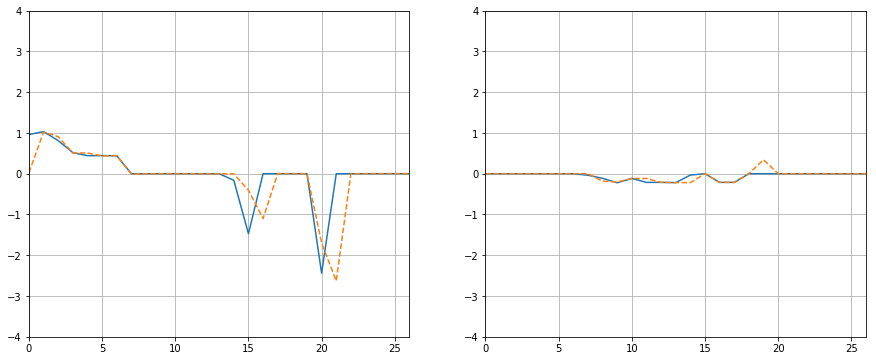

In [61]:
fig = plt.figure(figsize=(15,6))
for k in [0,1]:
    plt.subplot(1,2,k+1)
    plt.plot(u_eval_.squeeze().detach().numpy()[:,k])
    plt.plot(unstandardize_data(u, stats[0][:,:,4:], stats[1][:,:,4:]).squeeze().detach().numpy()[:,k],'--')
    plt.grid()
    plt.xlim([0, 26])
    plt.ylim([-4,4])


In [50]:
x_future, u_future = policy.propagate_n(T, x_train[:1,:,:])
complete_traj = policy.join_partial_future_signal(x_train[:1,:,:], x_future)

In [51]:
p = unstandardize_data(complete_traj, stats[0][:,:,:4], stats[1][:,:,:4]).detach()

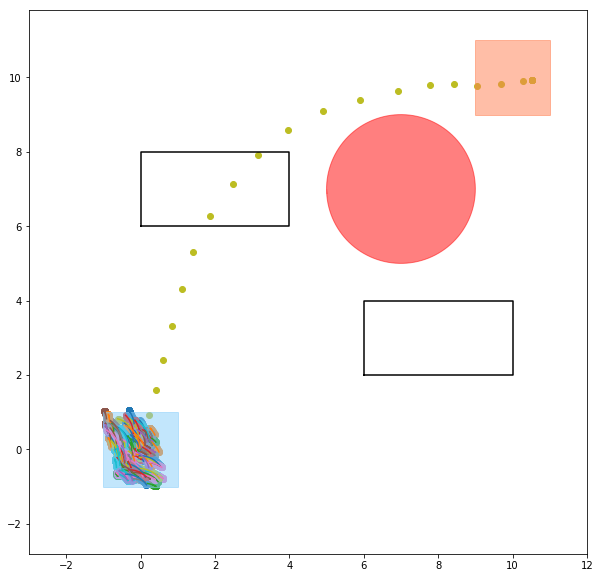

In [52]:
fig = plt.figure(figsize=(10,10))
cov_env.draw2D(kwargs=draw_params)
plt.axis("equal")
for j in range(ic_eval.shape[1]):
    plt.plot(traj_np[:,j,0], traj_np[:,j,1])
    plt.scatter(traj_np[:,j,0], traj_np[:,j,1])
plt.xlim([-3, 12])
plt.ylim([-3, 12])
plt.scatter(x_train_.squeeze().numpy()[:,0], x_train_.squeeze().numpy()[:,1])


In [58]:
def propagate_dynamics(dynamics, x0, us, stats=(torch.zeros([1,1,6]), torch.ones([1,1,6]))):
    xs = []
    xs.append(x0)
    for i in range(us.shape[0]):
        xs.append(dynamics(xs[-1], us[i:i+1,:,:], stats=stats))
    return torch.cat(xs, 0)

In [ ]:
def kinematic_bicycle_euler(x, u, dt=0.5, stats=(torch.zeros([1,1,6]), torch.ones([1,1,6]))):
    
    μ = stats[0]
    σ = stats[1]
    # unscale
    x, y, psi, V = unstandardize_data(x, μ[:,:,:4], σ[:,:,:4]).split(1, dim=-1)
    a, delta = unstandardize_data(u, μ[:,:,4:], σ[:,:,4:]).split(1, dim=-1)

    beta = torch.atan(lr / (lr + lf) * torch.tan(delta.clamp(delta_min, delta_max)))
    
    x_new = x + dt * V * torch.cos(psi + beta)
    y_new = y + dt * V * torch.sin(psi + beta)
    psi_new = psi + V / lr * torch.sin(beta)
    
    
    psi_new = psi + 0.5 * a * dt**2 * torch.sin(beta) / lr + dt * V * torch.sin(beta) / lr
    V_new = (a.clamp(a_min, a_max)*dt + V).clamp(V_min, V_max)
    
    x_new = x - lr * torch.sin(beta + psi) / torch.cos(beta) + lr * torch.sin(beta + psi_new) / torch.cos(beta)
    y_new = y + lr * torch.cos(beta + psi) / torch.cos(beta) - lr * torch.cos(beta + psi_new) / torch.cos(beta)
    # scale
    return standardize_data(torch.cat([x_new, y_new, psi_new, V_new], dim=-1), μ[:,:,:4], σ[:,:,:4])


In [ ]:
class ExpertDemoDataset(torch.utils.data.Dataset):

    def __init__(self, npy_file):
        
        # [t, x, y, psi, V]
        self.data = np.load(npy_file)
        self.max_length = self.data.shape[0]


    def __len__(self):
        return data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        time = self.data[idx, 0]
        state = np.zeros([self.max_length, 4])
        control = np.zeros([self.max_length, 2])
        state[:idx,:] = self.data[:idx, 1:5]
        control[:idx,:] = self.data[:idx, 5:7]
        
        
        return {'state': state, 'control': control, 'time': time, 'idx': idx}
    
    
def prepare_data(npy_file):
    # [t, x, y, psi, V, a, delta]
    data = np.load(npy_file)[:,1:]
    μ = np.mean(data, axis=0, keepdims=True)
    σ = np.std(data, axis=0, keepdims=True)
    x = torch.tensor(data[:, :4]).float().unsqueeze(1).requires_grad_(False)
    u = torch.tensor(data[:, 4:6]).float().unsqueeze(1).requires_grad_(False)
    return x, u, (torch.tensor(μ).float().unsqueeze(1).requires_grad_(False), torch.tensor(σ).float().unsqueeze(1).requires_grad_(False),)


def kinematic_bicycle(x, u, dt=0.5, stats=(torch.zeros([1,1,6]), torch.ones([1,1,2])), lr=0.7, lf=0.5, V_min=0.0, V_max=5.0, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
    '''
    x is [..., state_dim]
    u is [..., ctrl_dim]
    '''
    μ = stats[0]
    σ = stats[1]
    # unscale
    x, y, psi, V = (x * σ[:,:,:4] + μ[:,:,:4]).split(1, dim=-1)
    a, delta = (u * σ[:,:,4:] + μ[:,:,4:]).split(1, dim=-1)

    beta = torch.atan(lr / (lr + lf) * torch.tan(delta.clamp(delta_min, delta_max)))
    
    psi_new = psi + 0.5 * a * dt**2 * torch.sin(beta) / lr + dt *V * torch.sin(beta) / lr
    V_new = (a.clamp(a_min, a_max)*dt + V).clamp(V_min, V_max)
    x_new = x - lr * torch.sin(beta + psi) / torch.cos(beta) + lr * torch.sin(beta + psi_new) / torch.cos(beta)
    y_new = y + lr * torch.cos(beta + psi) / torch.cos(beta) - lr * torch.cos(beta + psi_new) / torch.cos(beta)
    # scale
    return (torch.cat([x_new, y_new, psi_new, V_new], dim=-1) - μ[:,:,:4]) / σ[:,:,:4]


def initial_conditions(n):
    good_samples = np.zeros([1,2*n,4])
    total = 0
    while total < n:
        x0 = np.random.rand(1,n,4)
        x0[:,:,:2] -= 0.5
        x0[:,:,:2] *= 2.0
        x0[:,:,2] *= np.pi/4 + 3 * np.pi/4
        x0[:,:,3] *= 2
        p = torch.tensor(x0).float()
        v = vf(p).squeeze().numpy() < 0
        num_new = np.sum(v)
        good_samples[:,total:num_new+total,:] = x0[:,v,:]
        total += num_new
    return good_samples[:,:n,:]


class InitialConditionDataset(torch.utils.data.Dataset):

    def __init__(self, n):
        self.n = n
        self.ic = initial_conditions(n)


    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.ic[:,idx,:]
    
def standardize_data(x, mu, sigma):
    return (x - mu)/sigma

def unstandardize_data(x, mu, sigma):
    return x * sigma + mu



    
class STLPolicy(torch.nn.Module):

    def __init__(self, dynamics, state_dim, ctrl_dim, hidden_dim, stats, num_layers=1, dt = 0.5, a_min=-3, a_max=3, delta_min=-0.344, delta_max=0.344):
        super(STLPolicy, self).__init__()
        
        self.dynamics = dynamics
        self.stats = stats
        self.dt = dt      
        self.state_dim = state_dim

        a_lim_ = torch.tensor([a_min, a_max]).float().unsqueeze(0).unsqueeze(0)
        delta_lim_ = torch.tensor([delta_min, delta_max]).float().unsqueeze(0).unsqueeze(0)
        self.a_lim = standardize_data(a_lim_, stats[0][:,:,4:5], stats[1][:,:,4:5])
        self.delta_lim = standardize_data(delta_lim_, stats[0][:,:,5:], stats[1][:,:,5:])
        
        self.lstm = torch.nn.LSTM(state_dim, hidden_dim, num_layers)
        self.proj = torch.nn.Sequential(torch.nn.Linear(hidden_dim, ctrl_dim), torch.nn.Tanh())
        self.initialize_rnn = [torch.nn.Linear(state_dim, hidden_dim),  torch.nn.Linear(state_dim, hidden_dim)]
        self.L2loss = torch.nn.MSELoss()
        

    def switch_device(self, device):
        self.a_lim.to(device)
        self.delta_lim.to(device)
        self.stats[0].to(device)
        self.stats[1].to(device)

    def initial_rnn_state(self, x0):
        # x0 is [bs, state_dim]
        return [l(x0) for l in self.initialize_rnn]
    
    def forward(self, x):        
        # x is [time_dim, bs, state_dim]
        h0 = self.initial_rnn_state(x[:1,:,:])

        o, _ = self.lstm(x, h0)    # [time_dim, bs, hidden_dim] , bs = 1 for a single expert trajectory.
        
        # [time_dim, bs, ctrl_dim]  projecting between u_min and u_max (standardize) since proj is between -1 and 1 due to tanh
        u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * self.proj(o) + self.a_lim.mean(-1, keepdims=True)
        return o, u
            
    
    def propagate_n(self, n, x_partial):
        '''
        n is the number of time steps to propagate forward
        x_partial is the input trajectory [time_dim, bs, state_dim]
        dynamics is a function that takes in x and u and gives the next state
        '''
        h0 = self.initial_rnn_state(x_partial[:1,:,:])

        x_future = []
        u_future = []
        
        o, h = self.lstm(x_partial, h0)    # h is the last hidden state/last output

        x_prev = x_partial[-1:, :,:]    # [1, bs, state_dim]

        for i in range(n):
            u_ = self.proj(h[0])    # [1, bs, ctrl_dim]
            u = (self.a_lim[:,:,1:] - self.a_lim[:,:,:1]) / 2 * u_ + self.a_lim.mean(-1, keepdims=True)
            u_future.append(u)
            x_next = self.dynamics(x_prev, u, stats=self.stats)    # [1, bs, state_dim]
            x_future.append(x_next)
            o, h = self.lstm(x_next, h)    # o, (h,c) are [1, bs, hidden_dim]

            x_prev = x_next
                
        return torch.cat(x_future, 0), torch.cat(u_future, 0)    # [n, bs, state_dim/ctrl_dim]
        
        
    def control_loss(self, x_partial, u_true):
        '''
        Encourage the policy to imitate the controls from the expert demonstration
        '''
        o, u = self.forward(x_partial)
        return self.L2loss(u, u_true)
    @staticmethod
    def join_partial_future_signal( x_partial, x_future):
        return torch.cat([x_partial, x_future], 0)
    
    def STL_loss_n(self, n, x_partial, formula, formula_input_func, **kwargs):
        '''
        Given partial trajectory, roll out the policy to get a complete trajectory.
        Encourage the complete trajectory to satisfy an stl formula
        '''
        x_future, u_future = self.propagate_n(n, x_partial)    # [n, bs, state_dim/ctrl_dim]
        x_complete = self.join_partial_future_signal(x_partial, x_future)
        signal = unstandardize_data(x_complete, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]
        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def STL_loss(self, x, formula, formula_input_func, **kwargs):
        signal = unstandardize_data(x, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim]).permute([1,0,2]).flip(1)    # [bs, time_dim, state_dim]

        return torch.relu(-formula.robustness(formula_input_func(signal), **kwargs)).mean()
    
    def HJI_loss(self, x_traj):
        '''
        x is [time_dim, bs, state_dim]
        Given a trajectory, compute the integral (finite differencing) of the value function along the trajectory
        Want the value to be negative (more negative the better)
        '''
        
        total_value = vf(unstandardize_data(x_traj, self.stats[0][:,:,:self.state_dim], self.stats[1][:,:,:self.state_dim])).squeeze(-1).sum(0) * self.dt    # [time_dim, bs, 1]

        return torch.relu(total_value).mean()

In [ ]:
class HJIValueFunction(torch.autograd.Function):
        
    @staticmethod
    def forward(ctx, input):
        """
        [bs, x_dim]
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return value_interp(input.split(1, dim=-1))

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        points = input.split(1, dim=-1)
        gr = torch.zeros_like(input)
        dim = input.shape[-1]
#         IPython.embed(banner1="poop")

        return  torch.cat([deriv_interp[i](points) for i in range(dim)], -1) * grad_output
    
vf = HJIValueFunction.apply
